## Analyze A/B Test Results

Andreas Fuchs

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [33]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [34]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [35]:
#How does it look like
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [36]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [37]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [38]:
len((df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')])) + \
len((df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]))

3893

f. Do any of the rows have missing values?

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [40]:
df2 = df.drop(df.index[(df['landing_page'] == 'new_page') & (df['group'] == 'control')])
df2 = df2.drop(df2.index[(df2['landing_page'] == 'old_page') & (df2['group'] == 'treatment')])

In [41]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [42]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [43]:
df2.set_index('user_id').index.get_duplicates()

[773192]

c. What is the row information for the repeat **user_id**? 

In [44]:
df2.loc[df.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [45]:
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [46]:
conv_all = (df2['converted'] == 1).sum() / len(df2.index)
print(conv_all)

0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [47]:
conv_control_prob = len((df2[(df2['group'] == 'control') & (df2['converted'] == 1)])) / (df2['group'] == 'control').sum()
print(conv_control_prob)

0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [48]:
conv_treat_prob = len((df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)])) / (df2['group'] == 'treatment').sum()
print(conv_treat_prob)

0.118808065515


d. What is the probability that an individual received the new page?

In [49]:
rec_new_prob = (df2['landing_page'] == 'new_page').sum() / len(df2.index)
print(rec_new_prob)

0.500061944223


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

In [50]:
print('Control group : ', conv_control_prob)
print('Treatment group: ', conv_treat_prob)

Control group :  0.1203863045
Treatment group:  0.118808065515


***Answer / conclusion:***  
We can see conversion probabilities of both control group and treatment group. Contol represents the old page, treatment represents new page.

The difference in probablities between both groups is less than 0,02 and not sufficient to indicate that one or another page lets users convert.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**  
For the null hypotheses we need the probability of conversion new landing page minus probability of the old page to be smaller or equal than 0.
(0.118808065515 - 0.1203863045 <= 0)  

For the alternative hypotheses we need the probability of conversion new landing page minus probability of the old page to be greater than 0.   
(0.118808065515 - 0.1203863045 > 0)

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [51]:
convert_rate = (df2['converted'] == 1).sum() / len(df2.index)
pnew = convert_rate
print(pnew)

0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [52]:
pold = pnew
print(pold)

0.119597087245


c. What is $n_{new}$?

In [53]:
nnew = (df2['landing_page'] == 'new_page').sum()
print(nnew)

145310


d. What is $n_{old}$?

In [54]:
nold = (df2['landing_page'] == 'old_page').sum()
print(nold)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [55]:
df_npc = df2[(df2['landing_page'] == 'new_page')]
conv = df_npc['converted']
new_page_converted = np.random.choice(conv, nnew)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [56]:
df_opc = df2[(df2['landing_page'] == 'old_page')]
conv = df_opc['converted']
old_page_converted = np.random.choice(conv, nold)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [57]:
pnew = new_page_converted.sum() / len(new_page_converted)
pold = old_page_converted.sum() / len(old_page_converted)
p = pnew - pold
print('pnew - pold = ', p)

pnew - pold =  -0.000587235435128


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [58]:
p_diffs = []
for i in range (10000):
    convert_new = np.random.choice([1,0], size=nnew, p=[convert_rate, (1 - convert_rate)])
    convert_old = np.random.choice([1,0], size=nold, p=[convert_rate, (1 - convert_rate)])
    p_diff = convert_new.mean() - convert_old.mean()
    p_diffs.append(p_diff)  

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

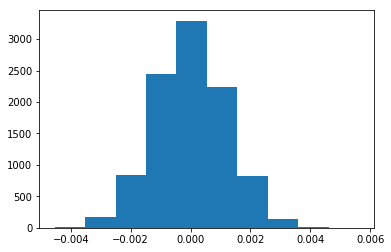

In [59]:
plt.hist(p_diffs)
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [60]:
prop_diff = [i for i in p_diffs if i > ( (conv_treat_prob) - conv_control_prob)]
print('Proportion of p_diffs is ' + str((len(prop_diff) / len(p_diffs))))

Proportion of p_diffs is 0.9111


k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**  
We calculated the p-value. That is the fraction of values (p_diffs) greater than all calculated values.
The higher the pvalue is the higher the probability of having a sample which represents our null hypotheses.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [61]:
import statsmodels.api as sm

convert_old = ((df2['converted'] == 1) & (df2['landing_page'] == 'old_page')).sum()
convert_new = ((df2['converted'] == 1) & (df2['landing_page'] == 'new_page')).sum()
n_old = (df2['landing_page'] == 'old_page').sum()
n_new = (df2['landing_page'] == 'new_page').sum()

/Volumes/EXTERN_MAC/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [62]:
from scipy.stats import norm

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
print('z_score', z_score)
print('norm.cdf', norm.cdf(z_score))
print('norm.ppf', norm.ppf(1-(0.05/2)))

z_score 1.31092419842
norm.cdf 0.905058312759
norm.ppf 1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**  
The critical value at 95% confidence is much more than our zscore. If we would like to challenge the null hypotheses I expect the zscore to be much higher.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**  
We should perform a linear regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [63]:
# Add column and convert treat / control to BOOL
df2['intercept'] = 1
df2['ab_page'] = df2['group'].replace(('treatment', 'control'), (1, 0))

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [64]:
# Fit and summarize OLS model
reg_mod = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
model = reg_mod.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [65]:
#Show summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.190
Time:                        08:56:59   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**Answer**  

Now in linear regression we have a different situation, as  

y = $\beta_0 + \beta_1 x$  
Null hypothesis is that the new landing page  = 0.
Alternative hypothesis would be that the old page  = 0.  

In Part II we showed that null hypothesis was like this  
Null: New landing page <= old landing page
Alternative: New page > old landing page

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**  
In general it would be a good idea to consider other factors. As our R squared value is 0, we see that the adaption quality of our regression model is very bad / not present. So it would definitely make sense to have a look on other factors. (in the following we will take the countries...)

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [66]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [67]:
# At frist some standards
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [68]:
#Number of countries
df_countries.country.nunique()

3

In [69]:
#Number of users (already known...)
df_countries.user_id.nunique()

290584

In [70]:
# join datasets
df_all = pd.merge(df2, df_countries, on='user_id')
df_all.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [71]:
#First divide the countries into new columns
df_all['US'] = df_all['country'].replace(('US', 'UK', 'CA'), (1, 0, 0))
df_all['UK'] = df_all['country'].replace(('US', 'UK', 'CA'), (0, 1, 0))
df_all['CA'] = df_all['country'].replace(('US', 'UK', 'CA'), (0, 0, 1))

In [72]:
df_all.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0,0


In [73]:
reg_mod_us = sm.OLS(df_all['converted'], df_all[['intercept', 'US']])
analysis_us = reg_mod_us.fit()
analysis_us.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01634
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.898
Time:                        08:56:59   Log-Likelihood:                -85268.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1197      0.001    108.797      0.000       0.118       0.122
US            -0.0002      0.001     -0.128      0.898      -0.003       0.002
==============================================================================
Omnibus:                   125554.657   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414321.504
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         3.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
reg_mod_uk = sm.OLS(df_all['converted'], df_all[['intercept', 'UK']])
analysis_uk = reg_mod_uk.fit()
analysis_uk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9121
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.340
Time:                        08:56:59   Log-Likelihood:                -85268.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1193      0.001    171.656      0.000       0.118       0.121
UK             0.0013      0.001      0.955      0.340      -0.001       0.004
==============================================================================
Omnibus:                   125554.026   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414317.226
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
reg_mod_ca = sm.OLS(df_all['converted'], df_all[['intercept', 'CA']])
analysis_ca = reg_mod_ca.fit()
analysis_ca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.653
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.103
Time:                        08:56:59   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1198      0.001    194.025      0.000       0.119       0.121
CA            -0.0045      0.003     -1.629      0.103      -0.010       0.001
==============================================================================
Omnibus:                   125552.776   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414308.692
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         4.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Answer**  

I can see almost no change in any data. So there seems not be any relevance of the country to our results.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [76]:
df_all['US_int'] = df_all['US']
df_all['UK_int'] = df_all['UK']
df_all['CA_int'] = df_all['CA']

In [77]:
reg_mod_us = sm.OLS(df_all['converted'], df_all[['US_int', 'ab_page']])
analysis_us = reg_mod_us.fit()
analysis_us.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                 1.465e+04
Date:                Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                        08:57:00   Log-Likelihood:                -89814.
No. Observations:              290584   AIC:                         1.796e+05
Df Residuals:                  290582   BIC:                         1.797e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
US_int         0.0926      0.001    102.110      0.000       0.091       0.094
ab_page        0.0539      0.001     50.204      0.000       0.052       0.056
==============================================================================
Omnibus:                   120830.646   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           382991.286
Skew:                           2.265   Prob(JB):                         0.00
Kurtosis:                       6.335   Cond. No.                         2.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
reg_mod_uk = sm.OLS(df_all['converted'], df_all[['UK_int', 'ab_page']])
analysis_uk = reg_mod_uk.fit()
analysis_uk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                 1.060e+04
Date:                Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                        08:57:00   Log-Likelihood:                -93544.
No. Observations:              290584   AIC:                         1.871e+05
Df Residuals:                  290582   BIC:                         1.871e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UK_int         0.0701      0.001     52.888      0.000       0.067       0.073
ab_page        0.1014      0.001    108.368      0.000       0.100       0.103
==============================================================================
Omnibus:                   118958.012   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           371353.163
Skew:                           2.232   Prob(JB):                         0.00
Kurtosis:                       6.277   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
reg_mod_ca = sm.OLS(df_all['converted'], df_all[['CA_int', 'ab_page']])
analysis_ca = reg_mod_ca.fit()
analysis_ca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     9329.
Date:                Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                        08:57:00   Log-Likelihood:                -94733.
No. Observations:              290584   AIC:                         1.895e+05
Df Residuals:                  290582   BIC:                         1.895e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CA_int         0.0569      0.003     20.189      0.000       0.051       0.062
ab_page        0.1159      0.001    130.166      0.000       0.114       0.118
==============================================================================
Omnibus:                   118898.747   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           370862.343
Skew:                           2.232   Prob(JB):                         0.00
Kurtosis:                       6.273   Cond. No.                         3.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Answer**  
## Conclusions 
Finally we can see some change in the data. The R-square and the intercept coefficients have changed (r-square went up, coeffs went down).
That means the adaption quality of our model was better than before, BUT due to the low values (far away from 1), we can conclue the null hypotheses (old landing page) to be the "winner".

